In [26]:
%load_ext autoreload
%autoreload 2
%cd /mlx_devbox/users/janne.spijkervet/repo/44/eurovision-dataset/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mlx_devbox/users/janne.spijkervet/repo/44/eurovision-dataset


In [27]:
from experiments.fit_model.prepare_data import prepare_inputs_targets

In [28]:
train_dataset, val_dataset = prepare_inputs_targets("data")

/mlx_devbox/users/janne.spijkervet/repo/44/eurovision-dataset/experiments/fit_model/prepare_data.py:72: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  draws,
/mlx_devbox/users/janne.spijkervet/repo/44/eurovision-dataset/experiments/fit_model/prepare_data.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df


Missing datapoints: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1261/1261 [00:23<00:00, 53.16it/s]


In [29]:
train_dataset["targets"].describe()

count    3.760000e+06
mean     1.975452e-02
std      1.036512e+00
min     -5.644482e+00
25%     -6.404888e-01
50%      8.550064e-02
75%      7.515509e-01
max      3.962520e+00
Name: targets, dtype: float64

<Axes: >

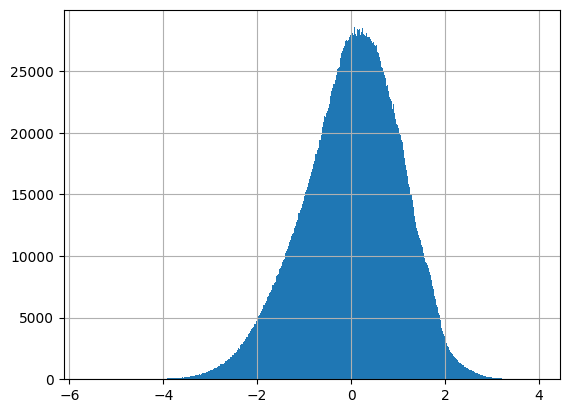

In [30]:
train_dataset["targets"].hist(bins=500)

<Axes: >

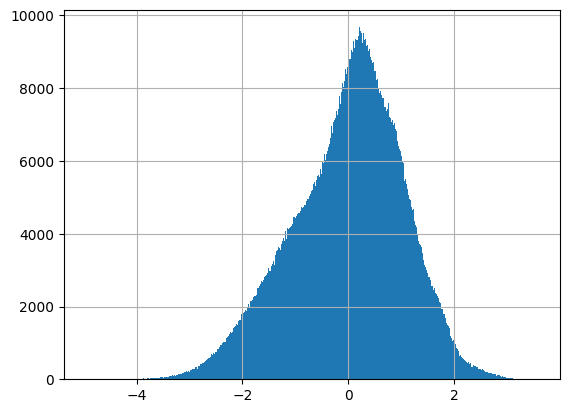

In [31]:
val_dataset["targets"].hist(bins=500)

In [32]:
val_dataset["targets"].var()

1.1113099127896666

In [33]:
0.78**2

0.6084